In [1]:
pip install -r requirements.txt


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words


empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents 

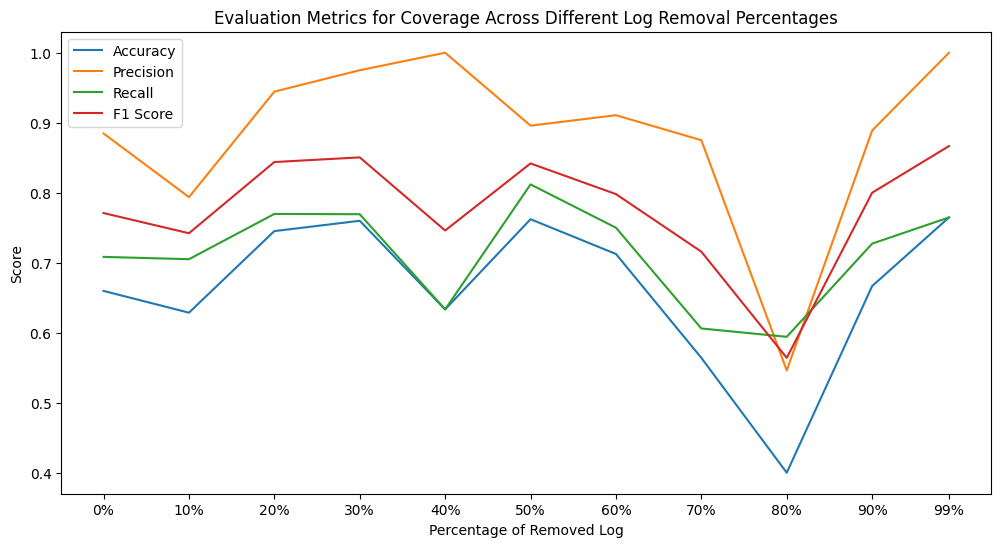

In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Function definitions (vectorize_log_file, extract_all_word_from_log, parse_execution_trace, 
# path_to_method_and_line_no, vectorize_execution_trace, extract_result, extract_line_from_result, 
# align_lists, evaluate_predictions) are the same as provided in the original code.

def vectorize_log_file(file_path, vectorizer=None, fit=True):
    all_sentence = []
    with open(file_path, 'r') as file:
        log_content = file.read().strip().split('\n')
        all_sentence.append(extract_all_word_from_log(log_content))
    if not log_content:
        raise ValueError(f"The log file {file_path} is empty or contains only whitespace.")
    if fit:
        log_vector = vectorizer.fit_transform(all_sentence)
    else:
        log_vector = vectorizer.transform(all_sentence)
    return log_vector.toarray()[0]

def extract_all_word_from_log(log_context):
    words = ""
    for line in log_context:
        words += line.split('|')[-1].strip()
    return words

def parse_execution_trace(file_path):
    return pd.read_csv(file_path)

def vectorize_execution_trace(trace_df, unique_methods, total_lines_of_code):
    execution_vectors = {}
    for method in unique_methods:
        coverage = {path: [0] * lines for path, lines in total_lines_of_code.items()}
        method_trace = trace_df[trace_df['signature'] == method]
        method = method.replace('src/test/java/functions/CalculatorTest.java;CalculatorTest.', '')
        method = method.replace('#', '')
        for _, row in trace_df.iterrows():
            if str(row['line_no']) in map(str, method_trace['line_no'].values):
                coverage[row['signature'].split(';')[0]][row['line_no'] - 1] = 1
        execution_vectors[method] = [x for y in coverage.values() for x in y]
    return execution_vectors

def extract_result(coverage_vector_result, total_lines_of_code):
    result = {}
    for path, lines in total_lines_of_code.items():
        result[path] = extract_line_from_result(coverage_vector_result[:lines])
        coverage_vector_result = coverage_vector_result[lines:]
    return result

def extract_line_from_result(result):
    lines = []
    for index, value in enumerate(result):
        if value == 1:
            lines.append(index)
    return lines

def align_lists(a, b):
    i, j = 0, 0
    new_a, new_b = [], []
    while i < len(a) and j < len(b):
        if a[i] == b[j]:
            new_a.append(a[i])
            new_b.append(b[j])
            i += 1
            j += 1
        elif a[i] < b[j]:
            new_a.append(a[i])
            new_b.append(0)
            i += 1
        else:
            new_a.append(0)
            new_b.append(b[j])
            j += 1
    while i < len(a):
        new_a.append(a[i])
        new_b.append(0)
        i += 1
    while j < len(b):
        new_a.append(0)
        new_b.append(b[j])
        j += 1
    return new_a, new_b

def evaluate_predictions(method_test, y_test, y_pred, total_lines_of_code):
    prediction_percentage = []
    preision_scores = []
    recall_scores = []
    f1_scores = []
    for i in range(len(y_test)):
        actual_coverage = extract_result(y_test[i], total_lines_of_code)
        predicted_coverage = extract_result(y_pred[i], total_lines_of_code)
        for path in total_lines_of_code.keys():
            actual = actual_coverage[path]
            predicted = predicted_coverage[path]
            actual, predicted = align_lists(actual, predicted)
        acc = accuracy_score(*align_lists(extract_line_from_result(y_test[i]), extract_line_from_result(y_pred[i])))
        prec = precision_score(y_test[i], y_pred[i])
        recall = recall_score(y_test[i], y_pred[i])
        f1 = f1_score(y_test[i], y_pred[i])
        prediction_percentage.append(acc)
        preision_scores.append(prec)
        recall_scores.append(recall)
        f1_scores.append(f1)
    return prediction_percentage, preision_scores, recall_scores, f1_scores

# Directory structure
base_directory = 'data/percentage_of_removed_log'

# Lists to store results
accuracies = []
precisions = []
recalls = []
f1s = []
percentages = []

total_lines_of_code = {
    'src/test/java/functions/CalculatorTest.java': 290,
    'src/main/java/functions/Calculator.java': 173,
    'src/main/java/functions/distributions/Calculator2.java': 9,
    'src/main/java/functions/distributions/Calculator3.java': 20,
}

# Iterate through each dataset directory
for folder in sorted(os.listdir(base_directory)):
    folder_path = os.path.join(base_directory, folder)
    if not os.path.isdir(folder_path):
        continue

    percentage = int(folder)
    percentages.append(percentage)

    log_directory = os.path.join(folder_path, 'logs')
    trace_file = os.path.join(folder_path, 'trace_data.csv')

    trace_df = parse_execution_trace(trace_file)
    trace_df['line_no'] = trace_df['path'].apply(lambda x: int(x.split('@')[1]))
    unique_methods = trace_df['signature'].unique()

    execution_vectors = vectorize_execution_trace(trace_df, unique_methods, total_lines_of_code)

    log_vectors = []
    execution_vectors_for_model = []
    method_names = [] 

    vectorizer = CountVectorizer()

    for method in unique_methods:
        method = method.replace('src/test/java/functions/CalculatorTest.java;CalculatorTest.', '')
        method = method.replace('#', '')
        log_file_path = os.path.join(log_directory, f"log_{method}.log")
        log_file_path = log_file_path.replace('"', '')

        if os.path.exists(log_file_path):
            try:
                log_vector = vectorize_log_file(log_file_path, vectorizer, fit=True)
                log_vectors.append(log_vector)
                execution_vectors_for_model.append(execution_vectors[method])
                method_names.append(method)
            except ValueError as e:
                print(e)
        else:
            print(f"Log file for method {method} not found.")

    if not log_vectors or not execution_vectors_for_model:
        raise ValueError("Log vectors or execution vectors for model are empty. Check your data.")

    max_log_length = max(len(v) for v in log_vectors)
    max_exec_length = max(len(v) for v in execution_vectors_for_model)

    padded_log_vectors = np.array([np.pad(v, (0, max_log_length - len(v)), 'constant') for v in log_vectors])
    padded_execution_vectors = np.array([np.pad(v, (0, max_exec_length - len(v)), 'constant') for v in execution_vectors_for_model])

    X = np.array(padded_log_vectors)
    y = np.array(padded_execution_vectors)

    y = y.astype(int)

    X_train, X_test, y_train, y_test, method_train, method_test = train_test_split(X, y, method_names, test_size=0.1, random_state=42)

    model = RandomForestClassifier()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    acc, prec, recall, f1 = evaluate_predictions(method_test, y_test, y_pred, total_lines_of_code)

    accuracies.append(np.mean(acc))
    precisions.append(np.mean(prec))
    recalls.append(np.mean(recall))
    f1s.append(np.mean(f1))

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(percentages, accuracies, label='Accuracy')
plt.plot(percentages, precisions, label='Precision')
plt.plot(percentages, recalls, label='Recall')
plt.plot(percentages, f1s, label='F1 Score')
plt.xlabel('Percentage of Removed Log')
plt.ylabel('Score')
plt.title('Evaluation Metrics for Coverage Across Different Log Removal Percentages')
plt.xticks(percentages, [f'{p}%' for p in percentages])
plt.legend()
plt.show()


In [17]:
accuracies

[np.float64(0.6597222222222222),
 np.float64(0.6286549707602339),
 np.float64(0.7451923076923077),
 np.float64(0.759906045751634),
 np.float64(0.6333333333333333),
 np.float64(0.7621527777777778),
 np.float64(0.7125),
 np.float64(0.5641025641025641),
 np.float64(0.4),
 np.float64(0.6666666666666666),
 np.float64(0.7647058823529411)]